## Deep Learning Approaches for RF-based detection & classification

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# import the torch packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch
import torchvision.models as models

# import custom functions
from helper_functions import *

### Load Images

In [2]:
feat_folder = '../Features/'
image_folder_name = 'IMG_PSD_256_2022-06-28'
arr_folder_name = 'ARR_SPEC_256_2022-06-28'

25000 files


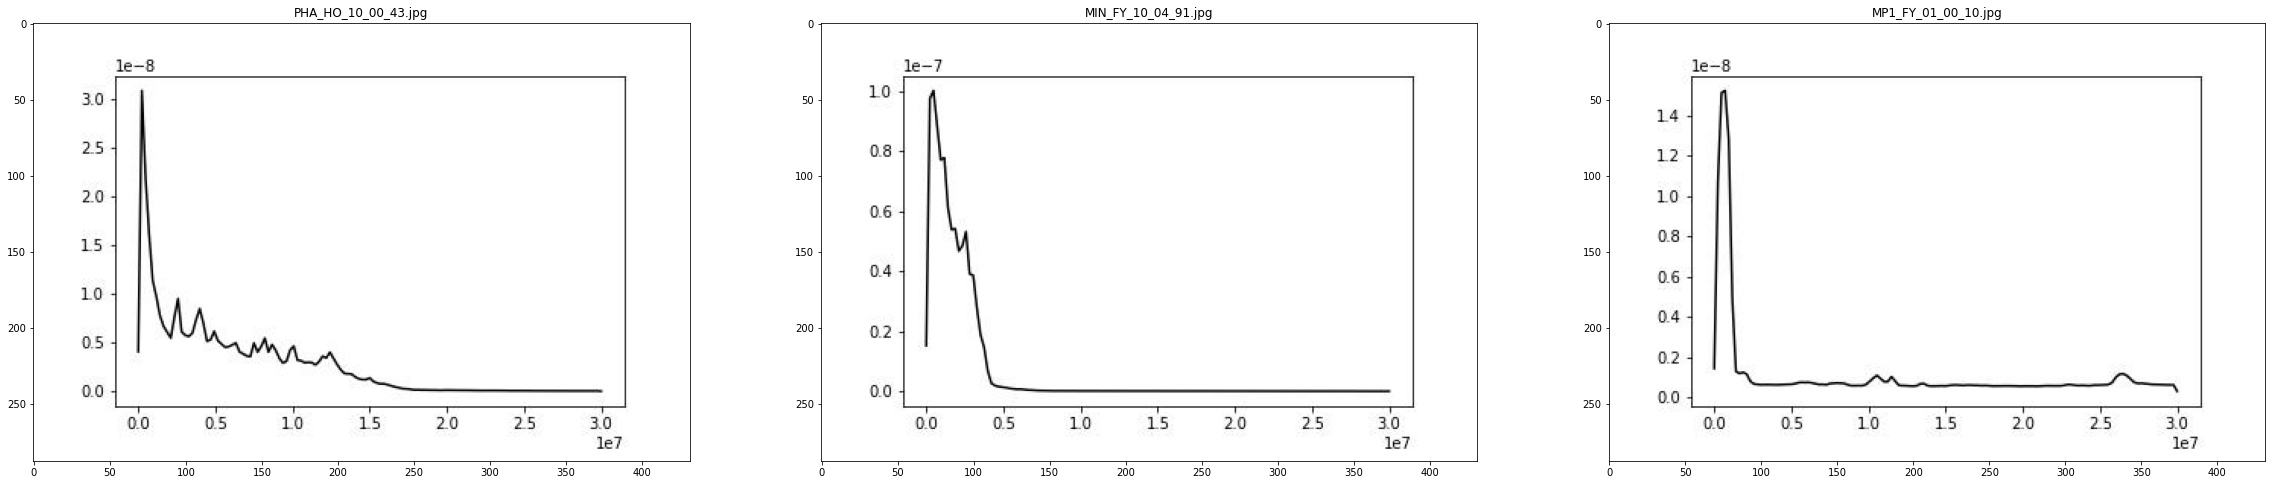

In [3]:
# visualize some examples
N_plot = 3
plt.figure(figsize=(40,40))
test_folder= feat_folder+image_folder_name
files = os.listdir(test_folder)
print(len(files),"files")
i_choose = random.sample(range(0, len(files)), N_plot)

for i in range(N_plot):
    file = files[i_choose[i]]
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,N_plot,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

### Load Numerical Features

In [4]:
feat_folder = '../Features/'
feat_name = 'SPEC'
datestr = '2022-06-29'
n_per_seg = 1024
interferences = ['WIFI']
Xs_arr, y_arr = load_features_arr(feat_folder, feat_name, datestr, n_per_seg, interferences)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:44<00:00,  3.46s/it]


### Dataset classes

In [ ]:
## images dataset
class RFGraphData(Dataset):
    def __init__(self, Xarr, yarr):
        self.path = path
    
    

In [5]:
## Create a dataset class
## Creating a custom dataset
class DroneDetectData(Dataset): ## NUMBERICAL DATA
    def __init__(self, Xarr, yarr):
        self.Xarr = Xarr
        test_list=[]
        for ya in yarr:
            if ya == 'AIR':
                num= 1.
            if ya == 'DIS':
                num= 2.
            if ya == 'INS':
                num= 3.
            if ya == 'MIN':
                num= 4.
            if ya == 'MP1':
                num= 5.
            if ya == 'MP2':
                num= 6.
            if ya == 'PHA':
                num= 0.
            test_list.append(num)
        self.yarr = np.array(test_list)
        print(len(self.yarr))
        
    def __len__(self):
        return len(self.yarr)
    
    def __getitem__(self, index):
        # all data must be in float and tensor format
        X = torch.tensor((self.Xarr[index]))
        X = X.unsqueeze(0)
        y = torch.tensor(float(self.yarr[index]))
        return (X, y)

In [6]:
dataset = DroneDetectData(Xs_arr, y_arr)

650


In [7]:
dataset.__getitem__(10)[0].shape

torch.Size([1, 513, 13392])

### 1. Custom NN

In [96]:
## Model settings
# Hyperparameters
batch_size = 8 # the number of samples processed before the model is updated. (number of samples in the training data)
num_classes = 7
learning_rate = 0.01
num_epochs = 100

# Device will determine whether to run the training on GPU or CPU.
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [97]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.avpool0 = nn.AvgPool2d(kernel_size=(50,200))
#         self.conv1 = nn.Conv2d(1, 8, 100)
#         self.avgpool1 = nn.AvgPool2d(kernel_size=3)
#         self.conv2 = nn.Conv2d(8, 8, 50)
#         self.conv3 = nn.Conv1d(64,128, 3)
#         self.conv4 = nn.Conv1d(128, 128, 3)
        self.dense = nn.Linear(660, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
         # Max pooling over a (2, 2) window
        x = self.avpool0(x)
#         x = self.conv1(x)
#         x = self.avgpool1(x)
#         x = self.conv2(x)
#         x = self.avgpool1(x)
#         x = nn.Dropout(p=0.25)(x)
        x = torch.flatten(x,1)
        x = self.dense(x)
        return x

In [95]:
## Test a random input
batch_size = 8
input = torch.randn(batch_size, 1, 513, 13392)
# input_1d = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype = torch.float)

net = ConvNeuralNet(7)
out = net(input)
print(input.shape)
print(out.shape)

torch.Size([8, 1, 513, 13392])
torch.Size([8, 7])


In [98]:
## Set up Data
train_split_percentage = 0.7
split_lengths = [int(train_split_percentage*len(dataset)), len(dataset)-int(train_split_percentage*len(dataset))]
train_set, test_set = torch.utils.data.random_split(dataset, split_lengths)

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                           batch_size = batch_size,
                                           shuffle = True)

In [99]:
model = ConvNeuralNet(num_classes)
model = model.to(device)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

In [100]:
# Training
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
    #Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader): 
        labels = labels.type(torch.long)

        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if i%10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


KeyboardInterrupt: 

In [94]:
## Check accuracy
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
#         images = images.repeat(1,3,1)
#         images = images.reshape(batch_size, 3, 1, 513)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(total, 100 * correct / total))


tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4], device='cuda:0')
Accuracy of the network on the 196 train images: 30.102040816326532 %


### 2. Transfer learning from Resnet50 & Apply Logistic Regression (Swinney paper)

In [101]:
# use pretrained resnet feature and just keep up to the last layer
resnet50 = models.resnet50(pretrained=True)
modules=list(resnet50.children())[:-1]
# resnet50=nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False

In [127]:
# test resnet
input = torch.randn(1,1,30,300)
inputr = input.repeat(1,3,1,1)
resnet50(inputr).shape

torch.Size([1, 1000])

In [ ]:
resnet_feats = []
resnet_y = []
for n in range(len(dataset)):
    d = dataset.__getitem__(n)
    inarr = d[0]
    inputr = inarr.repeat(1,3,1,1)
    out = resnet50(inputr)
    resnet_feats.append(np.array(out))
    resnet_y.append(np.array(d[1]))

resnet_feats = np.array(resnet_feats)
resnet_y = np.array(resnet_y)

In [ ]:
from sklearn.linear_model import LogisticRegression
# split data into K-fold
k_fold = 10
cv = KFold(n_splits=k_fold, random_state=1, shuffle=True)

# model parameters
Cs=list(map(lambda x:pow(2,x),range(-10,10,2)))

best_params_ls = []
score_ls = []

parameters = {'C':Cs}

for train_ix, test_ix in cv.split(resnet_feats):
    
    # find the optimal hypber parameters
    lr = LogisticRegression(max_iter=10000)
    clf = GridSearchCV(lr, parameters, n_jobs=1)
    clf.fit(resnet_feats[train_ix], resnet_y[train_ix])
    
    print(clf.best_params_)
    best_params_ls.append(clf.best_params_)
    
    # predict on the test data
    y_pred = clf.predict(resnet_feats[test_ix])
    acc = accuracy_score(resnet_y[test_ix], y_pred)
    print(acc)
    score_ls.append(acc)
    
print(feat_file_name+': ResNet+LR average test score:', np.mean(score_ls))